##**Import all neceassary packages**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

##**Model - Define DenseNet Model**

### Fire



In [ ]:
class Fire(nn.Module):
  def __init__(self, in_channels, s1x1, e1x1, e3x3):
    super(Fire, self).__init__()

    self.relu = nn.ReLU()
    self.squeeze = nn.Conv2d(in_channels, s1x1, 1, stride=1, padding=0)
    self.expand1x1 = nn.Conv2d(s1x1, e1x1, 1, stride=1, padding=0)
    self.expand3x3 = nn.Conv2d(s1x1, e3x3, 3, stride=1, padding=1)

  def forward(self, x):
    x = self.relu(self.squeeze(x))
    x = torch.cat([self.relu(self.expand1x1(x)), self.relu(self.expand3x3(x))], dim=1)
    return x

### Declare SqueezeNet model

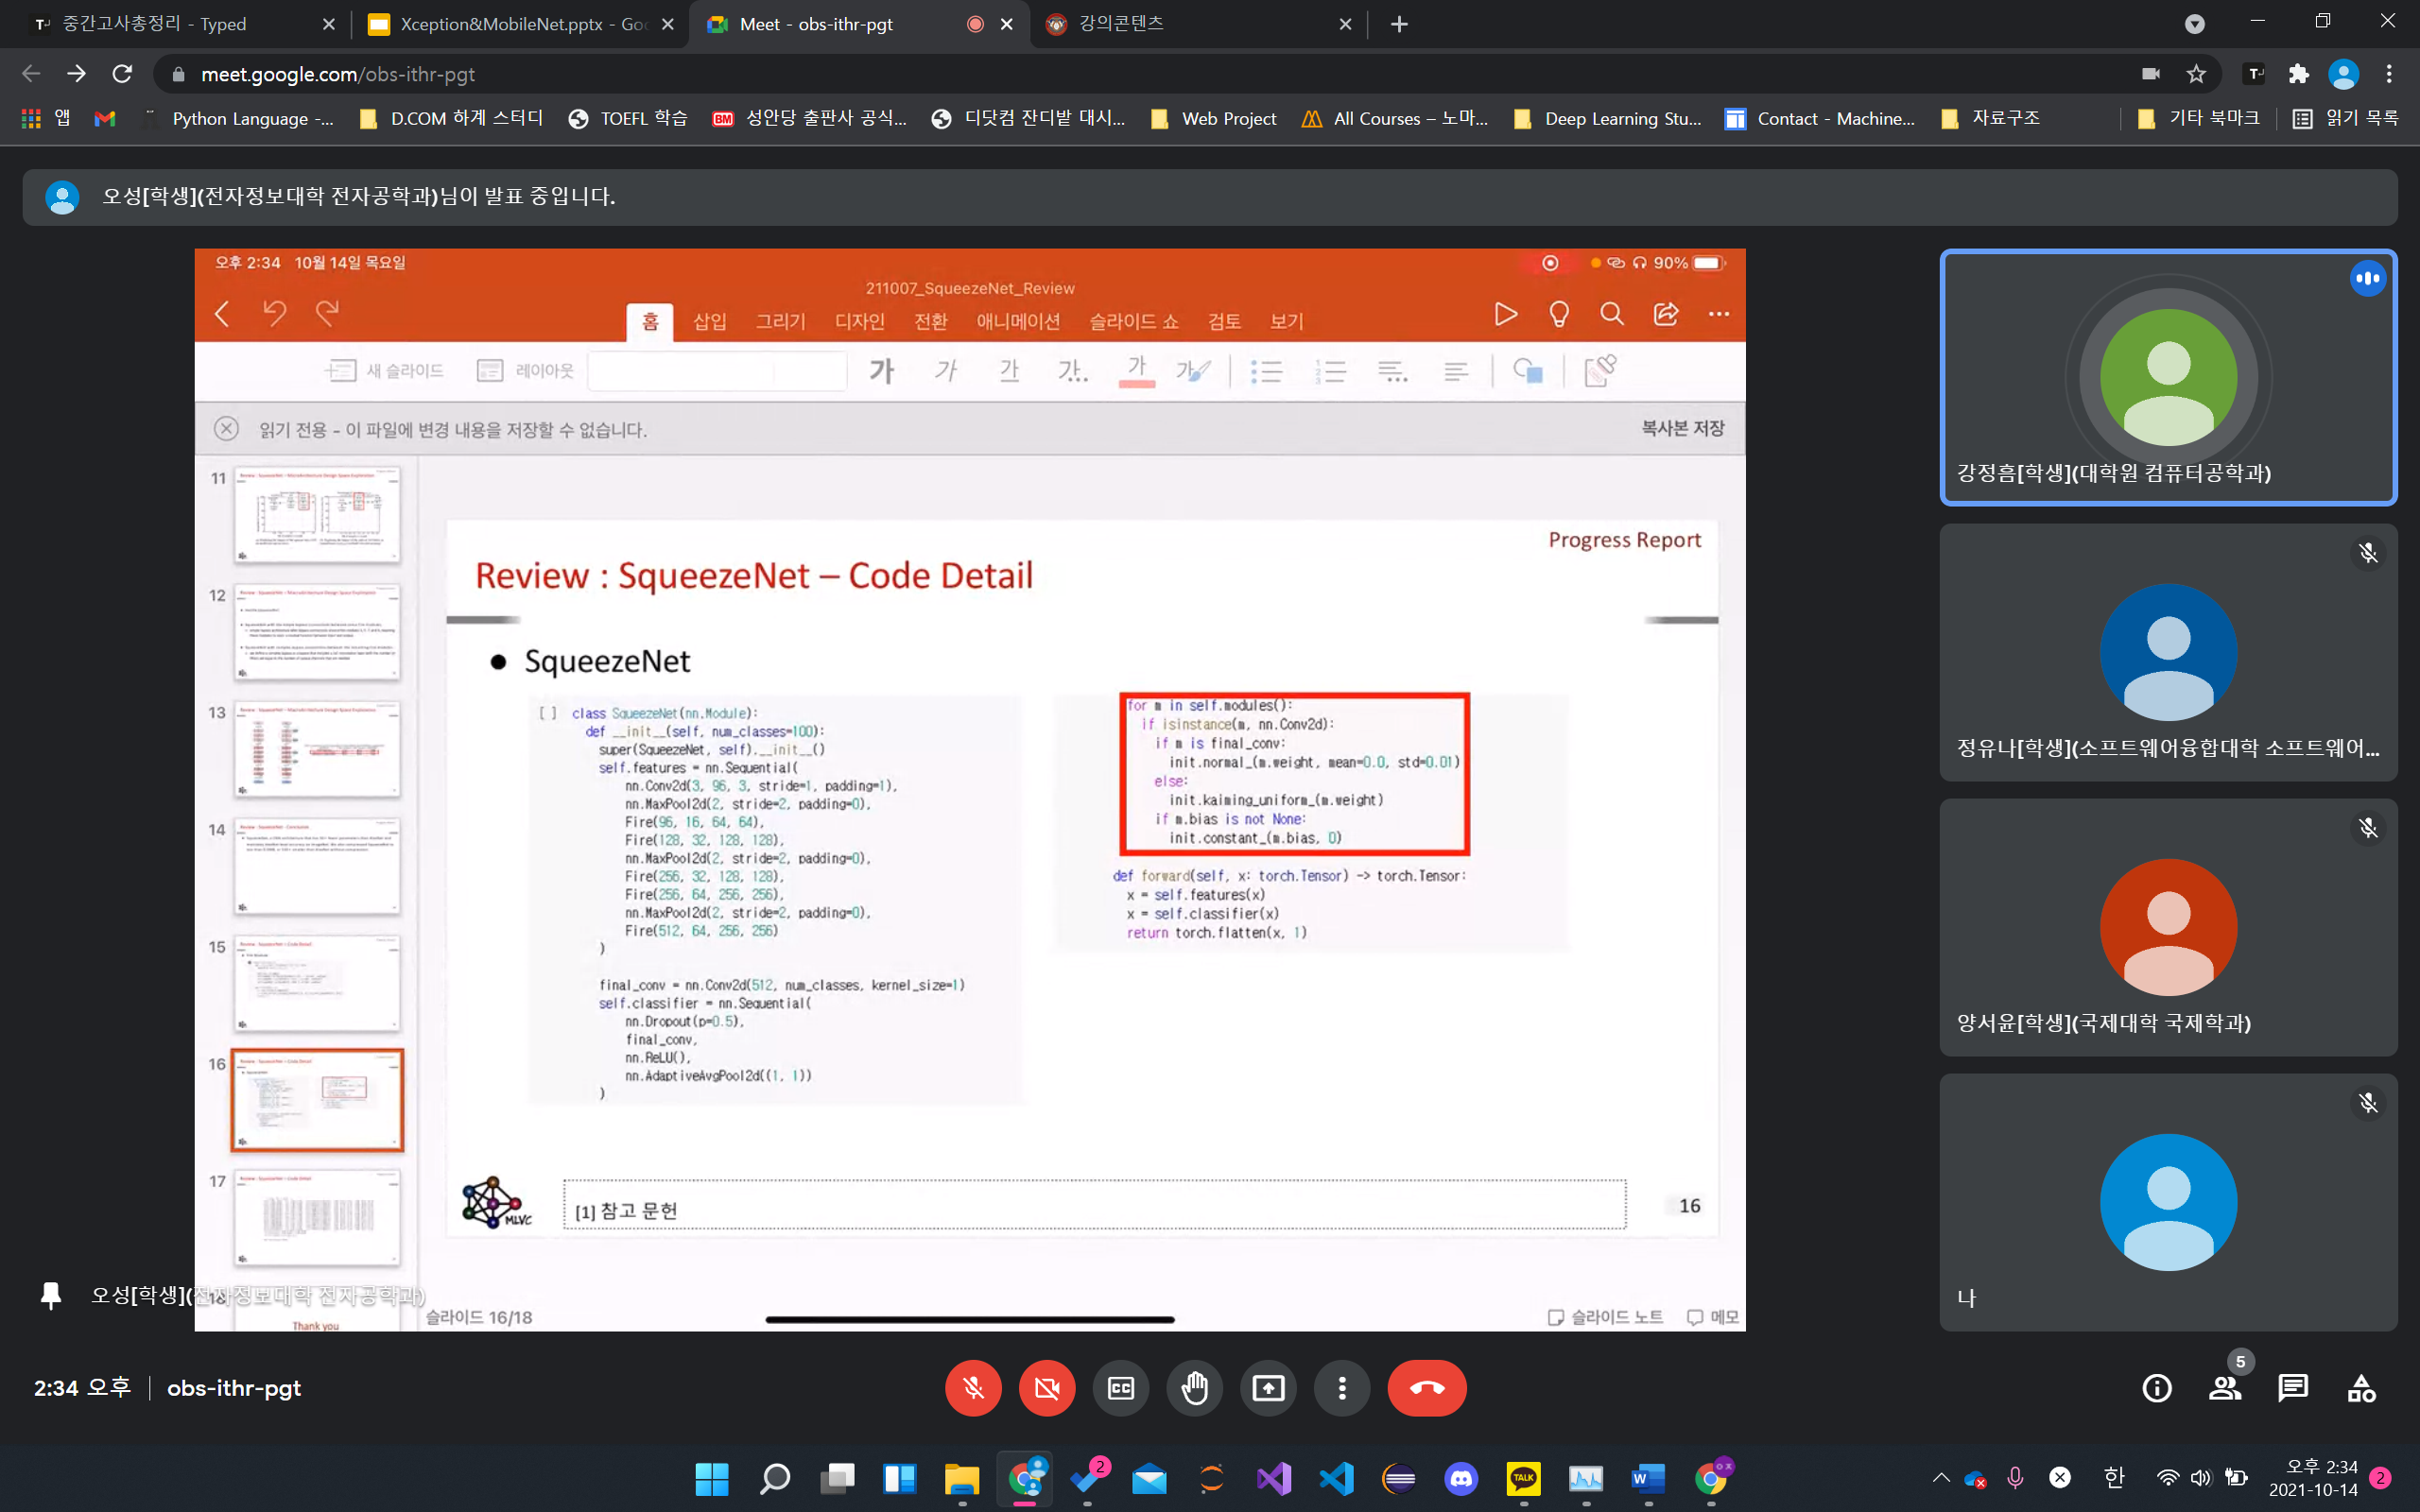

In [ ]:
# weight 초기화 적용해야한다.

class SqueezeNet(nn.Module):
  def __init__(self, num_classes=100):
    super(SqueezeNet, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 96, 7, stride=1, padding=3),
        nn.MaxPool2d(2, stride=2, padding=0),
        Fire(96, 16, 64, 64),
        Fire(128, 16, 64, 64),
        Fire(128, 32, 128, 128),
        nn.MaxPool2d(2, stride=2, padding=0),
        Fire(256, 32, 128, 128),
        Fire(256, 48, 192, 192),
        Fire(384, 48, 192, 192),
        Fire(384, 64, 256, 256),
        nn.MaxPool2d(2, stride=2, padding=0),
        Fire(512, 64, 256, 256),
        nn.Conv2d(512, num_classes, 1, stride=1, padding=0),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1))
    )

  def forward(self, x):
    x = self.features(x)
    return torch.flatten(x, 1)

### check model & model summary

In [ ]:
# check model
x = torch.randn(3, 3, 64, 64)
model = DenseNet_121()
output = model(x)
print(output.size())

torch.Size([3, 10])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# print model summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
summary(model, (3, 64, 64), device=device.type)

RuntimeError: ignored

##**Utils**

In [ ]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

##**Cutout: Main Code for Applying Cutout data augmentation**

In [ ]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

##**Parameter Settings**

In [ ]:
dataset = 'cifar100' # cifar10 or cifar100
model = 'SqueezeNet' # resnet18, resnet50, resnet101
batch_size = 128  # Input batch size for training (default: 128)
epochs = 150 # Number of epochs to train (default: 200)
learning_rate = 0.1 # Learning rate
data_augmentation = True # Traditional data augmentation such as augmantation by flipping and cropping?
path2weights = './drive/MyDrive/DeepLearning_competition/Internship/Week_3/SqueezeNet.pth'    # route for model savings
path2LatestWeights = './drive/MyDrive/DeepLearning_competition/Internship/Week_3/SqueezeNet_latest.pth'    # route for latest model savings

cutout = False # Apply Cutout?
n_holes = 1 # Number of holes to cut out from image
length = 16 # Length of the holes

seed = 0 # Random seed (default: 0)
print_freq = 30
cuda = torch.cuda.is_available()
cudnn.benchmark = True  # Should make training should go faster for large model


torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

test_id = dataset + '_' + model

### test cuda

In [ ]:
! nvidia-smi

Thu Oct  7 04:09:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##**Load and preprocess data**

In [ ]:
# Image Preprocessing
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

# train
train_transform = transforms.Compose([])

train_transform.transforms.append(transforms.Resize((64, 64)))
if data_augmentation:
    #train_transform.transforms.append(transforms.RandomCrop(299, 299))
    train_transform.transforms.append(transforms.RandomHorizontalFlip())
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(normalize)

if cutout:
    train_transform.transforms.append(Cutout(n_holes=n_holes, length=length))

# test
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    normalize])

if dataset == 'cifar10':
    num_classes = 10
    train_dataset = datasets.CIFAR10(root='data/',
                                     train=True,
                                     transform=train_transform,
                                     download=True)

    test_dataset = datasets.CIFAR10(root='data/',
                                    train=False,
                                    transform=test_transform,
                                    download=True)
elif dataset == 'cifar100':
    num_classes = 100
    train_dataset = datasets.CIFAR100(root='data/',
                                      train=True,
                                      transform=train_transform,
                                      download=True)

    test_dataset = datasets.CIFAR100(root='data/',
                                     train=False,
                                     transform=test_transform,
                                     download=True)


# Data Loader (Input Pipeline)
train_loader = DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

test_loader = DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/
Files already downloaded and verified


### show sample image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


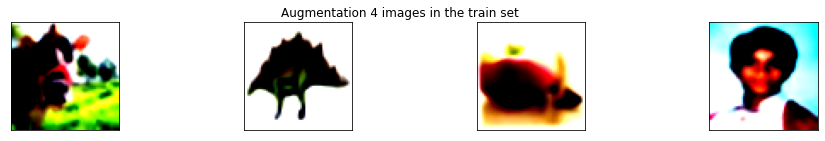

In [ ]:
x_train, x_train_label = [],[]
for i in range(4):
  img,label = train_dataset[i]
  x_train.append(img)
  x_train_label.append(label)

plt.figure(figsize=(16,2))
plt.suptitle("Augmentation 4 images in the train set")
for i in range(4):
  plt.subplot(1,4,i+1)
  x_train_tr = np.transpose(x_train[i], (1, 2, 0))
  plt.imshow(x_train_tr)
  plt.xticks([]); plt.yticks([])

##**Main Training**

In [ ]:
def train(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        input = input.cuda()
        target = target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            progress.print(i)

    print('==> Train Accuracy: Acc@1 {top1.avg:.3f} || Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    return top1.avg

def test(test_loader,epoch, model):
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    model.eval()
    for i,(input,target) in enumerate(test_loader):
        input = input.cuda()
        target = target.cuda()

        output = model(input)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))
    print('==> Test Accuracy:  Acc@1 {top1.avg:.3f} || Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    return top1.avg

In [ ]:
model = SqueezeNet().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=5e-4)

from torch.optim.lr_scheduler import MultiStepLR
scheduler = MultiStepLR(optimizer, milestones=[60, 90, 120], gamma=0.2)

criterion = torch.nn.CrossEntropyLoss().cuda()

In [ ]:
best_acc = 0
for epoch in range(epochs):
    print("\n----- epoch: {}/{}, lr: {} -----".format(
        epoch+1, epochs, optimizer.param_groups[0]["lr"]))

    # train for one epoch
    start_time = time.time()
    train(train_loader, epoch, model, optimizer, criterion)
    test_acc = test(test_loader,epoch,model)

    elapsed_time = time.time() - start_time
    print('==> {:.2f} seconds to train this epoch\n'.format(elapsed_time))
    
    # learning rate scheduling
    scheduler.step()
    
    # Save model for best accuracy
    if best_acc < test_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), path2weights)

#torch.save(model.state_dict(),path2LatestWeights)
print(f"Best Top-1 Accuracy: {best_acc}")


----- epoch: 1/150, lr: 0.1 -----


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0][  0/391]	Time  0.736 ( 0.736)	Loss 4.6055e+00 (4.6055e+00)	Acc@1   0.78 (  0.78)	Acc@5   4.69 (  4.69)
Epoch: [0][ 30/391]	Time  0.061 ( 0.083)	Loss 4.6033e+00 (4.6059e+00)	Acc@1   1.56 (  1.21)	Acc@5   3.91 (  5.17)
Epoch: [0][ 60/391]	Time  0.062 ( 0.073)	Loss 4.6058e+00 (4.6060e+00)	Acc@1   2.34 (  0.99)	Acc@5   5.47 (  4.92)
Epoch: [0][ 90/391]	Time  0.062 ( 0.069)	Loss 4.6092e+00 (4.6060e+00)	Acc@1   0.00 (  0.93)	Acc@5   3.12 (  4.93)
Epoch: [0][120/391]	Time  0.062 ( 0.067)	Loss 4.6057e+00 (4.6058e+00)	Acc@1   0.78 (  0.99)	Acc@5   4.69 (  4.96)
Epoch: [0][150/391]	Time  0.062 ( 0.066)	Loss 4.6056e+00 (4.6058e+00)	Acc@1   1.56 (  0.97)	Acc@5   2.34 (  4.93)
Epoch: [0][180/391]	Time  0.062 ( 0.066)	Loss 4.6052e+00 (4.6058e+00)	Acc@1   0.78 (  0.93)	Acc@5   6.25 (  4.93)
Epoch: [0][210/391]	Time  0.062 ( 0.065)	Loss 4.6052e+00 (4.6057e+00)	Acc@1   1.56 (  0.92)	Acc@5   3.12 (  5.05)
Epoch: [0][240/391]	Time  0.061 ( 0.065)	Loss 4.6052e+00 (4.6056e+00)	Acc@1   0.00 (  0.

KeyboardInterrupt: ignored